# Implementation of clustering algorithms

Build K-Means and Agglomerative Clustering models to perform an unsupervised clustering by using given data. Follow below steps as a guideline for building your model and explain each of them in code lines. 

* Data cleaning 

Start with data cleaning to ensure that your data is correct, consistent and usable. The techniques used for data cleaning may vary but you can consider to follow these basic steps: handling missing values, encoding categorical features, extracting useful features by using existing features, handling outliers etc.

* Data Preprocessing

In this step you should transform raw data into an understandable format for machine learning algorithms. This step may include scaling the features, performing dimensionality reduction etc.

* Clustering 

The goal of this step is to find distinct groups or “clusters” within a data set by using K-Means and Agglomerative Clustering Algorithms. Apply Elbow Method to determine the number of clusters. After building models, examine and comment the clusters formed via scatter plot.

* Silhouette Scores 

To evaluate how “well clustered” data points are, use the “silhouette score” and plot the Silhouette Scores for all of data points.

Note: Don't forget to explain your codes and comment on the obtained result.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

## Data Exploration

In [2]:
data = pd.read_csv("dataset.csv")
print(data.shape)
display(data.head())

(1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
print(data.isnull().sum()) # I checked if there is any null values.

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [4]:
for column in data.columns:
    print("------{}-------".format(column))
    print(data[column].describe())

# Described the columns to see outliers if there are any.

------age-------
count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64
------sex-------
count     1338
unique       2
top       male
freq       676
Name: sex, dtype: object
------bmi-------
count    1338.000000
mean       30.663397
std         6.098187
min        15.960000
25%        26.296250
50%        30.400000
75%        34.693750
max        53.130000
Name: bmi, dtype: float64
------children-------
count    1338.000000
mean        1.094918
std         1.205493
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         5.000000
Name: children, dtype: float64
------smoker-------
count     1338
unique       2
top         no
freq      1064
Name: smoker, dtype: object
------region-------
count          1338
unique            4
top       southeast
freq            364
Name: region, dtype: object
------charges------

I look the numerical features for outliers. Age, bmi and children seems right. Min and max values are reasonable. But there is high std in charges. So I wanted to look at its countplot. 

<AxesSubplot:xlabel='charges', ylabel='Count'>

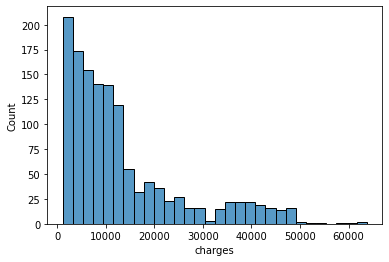

In [5]:
sns.histplot(data= data, x="charges")

Here, we can see there is a big dropdown after 50k. Let's look at this on scatterplot if they are really outliers.

There are 7 values which are greater than 50k


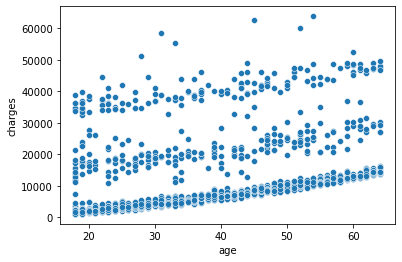

In [6]:
sns.scatterplot(data=data, x="age", y="charges")

count = (data["charges"] > 50000).sum()

print("There are {} values which are greater than 50k".format(count))

As we can see, there are 7 values greater than 50k and we can drop them to have a better dataframe.

<AxesSubplot:xlabel='age', ylabel='charges'>

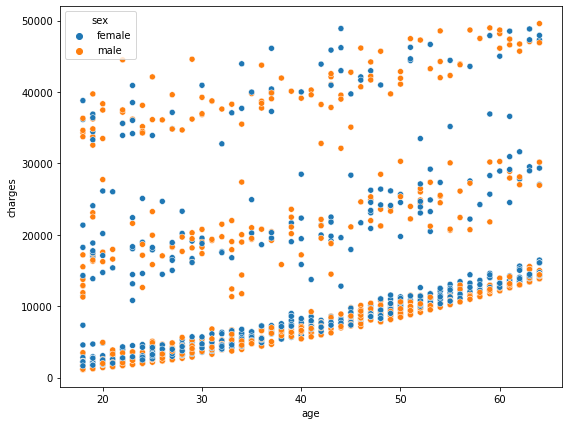

In [7]:
data_filtered = data[data["charges"]<=50000]
plt.figure(figsize=(9,7))
sns.scatterplot(data=data_filtered, x="age", y="charges",hue="sex")

## Preprocessing

In [8]:
display(data_filtered.head())

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [9]:
# Replacing binary features.
data_filtered["sex"].replace(["female","male"], [0,1], inplace=True)
data_filtered["smoker"].replace(["no","yes"], [0,1], inplace=True)

In [10]:
'''
# Replacing non-binary features.
dummies = pd.get_dummies(data_filtered["region"],prefix="reg")
data_filtered = pd.concat([data_filtered,dummies],axis=1)

data_filtered.drop(["region"],axis=1, inplace=True)
'''

data_filtered.drop('region',inplace=True, axis=1)

At this block I tried two things. First I tried to use region feature to evaluate clusters but KNN model tended to have a strong bias with the region. So I dropped it to have a cleaner model.

In [11]:
display(data_filtered.head())

,age,sex,bmi,children,smoker,charges
0,19,0,27.900,0,1,16884.92400
1,18,1,33.770,1,0,1725.55230
2,28,1,33.000,3,0,4449.46200
3,33,1,22.705,0,0,21984.47061
4,32,1,28.880,0,0,3866.85520


We have converted every categorical feature to numeric. So now, we can scale them. 

In [12]:
#Importing the MinMax Scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(data_filtered)

data_cleaned = pd.DataFrame(scaled, columns=data_filtered.columns)

I imported two scalers to try, when I tried to use StandardScaler it yielded 2 clusters in the elbow method and the result was not promising, so I changed it to MinMaxScaler

In [13]:
display(data_cleaned.head())

,age,sex,bmi,children,smoker,charges
0,0.021739,0.0,0.321227,0.0,1.0,0.325308
1,0.000000,1.0,0.479150,0.2,0.0,0.012458
2,0.217391,1.0,0.458434,0.6,0.0,0.068673
3,0.326087,1.0,0.181464,0.0,0.0,0.430549
4,0.304348,1.0,0.347592,0.0,0.0,0.056649


<AxesSubplot:xlabel='age', ylabel='charges'>

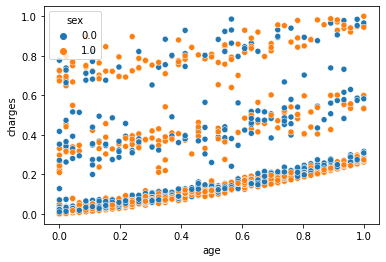

In [14]:
sns.scatterplot(data=data_cleaned, x="age",y="charges",hue="sex")

## Modeling

### Elbow Method for Number of Clusters

In [15]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(data_cleaned)

KMeans(n_clusters=3, random_state=0)

In [16]:
kmeans.labels_

array([2, 0, 0, ..., 1, 1, 2])

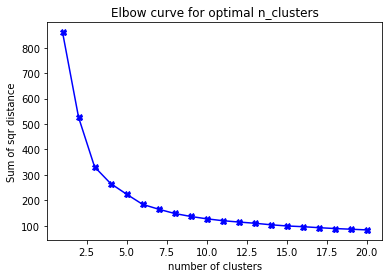

In [17]:
#Elbow Curve
sum_of_squared_distance = []

K = range(1,21)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_cleaned)
    sum_of_squared_distance.append(km.inertia_)

plt.plot(K,sum_of_squared_distance,"bX-")
plt.xlabel("number of clusters")
plt.ylabel("Sum of sqr distance")
plt.title("Elbow curve for optimal n_clusters")
plt.show()

Here I decided to select 4 as number of clusters.

### K-Means Clustering

In [18]:
km = KMeans(n_clusters = 4)
km.fit(data_cleaned)

KMeans(n_clusters=4)

In [19]:
cluster_label = km.labels_
data_filtered["KMeans_label"] = cluster_label
data_filtered.head()

,age,sex,bmi,children,smoker,charges,KMeans_label
0,19,0,27.900,0,1,16884.92400,0
1,18,1,33.770,1,0,1725.55230,1
2,28,1,33.000,3,0,4449.46200,1
3,33,1,22.705,0,0,21984.47061,1
4,32,1,28.880,0,0,3866.85520,1


In [20]:
data_filtered.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'charges', 'KMeans_label'], dtype='object')

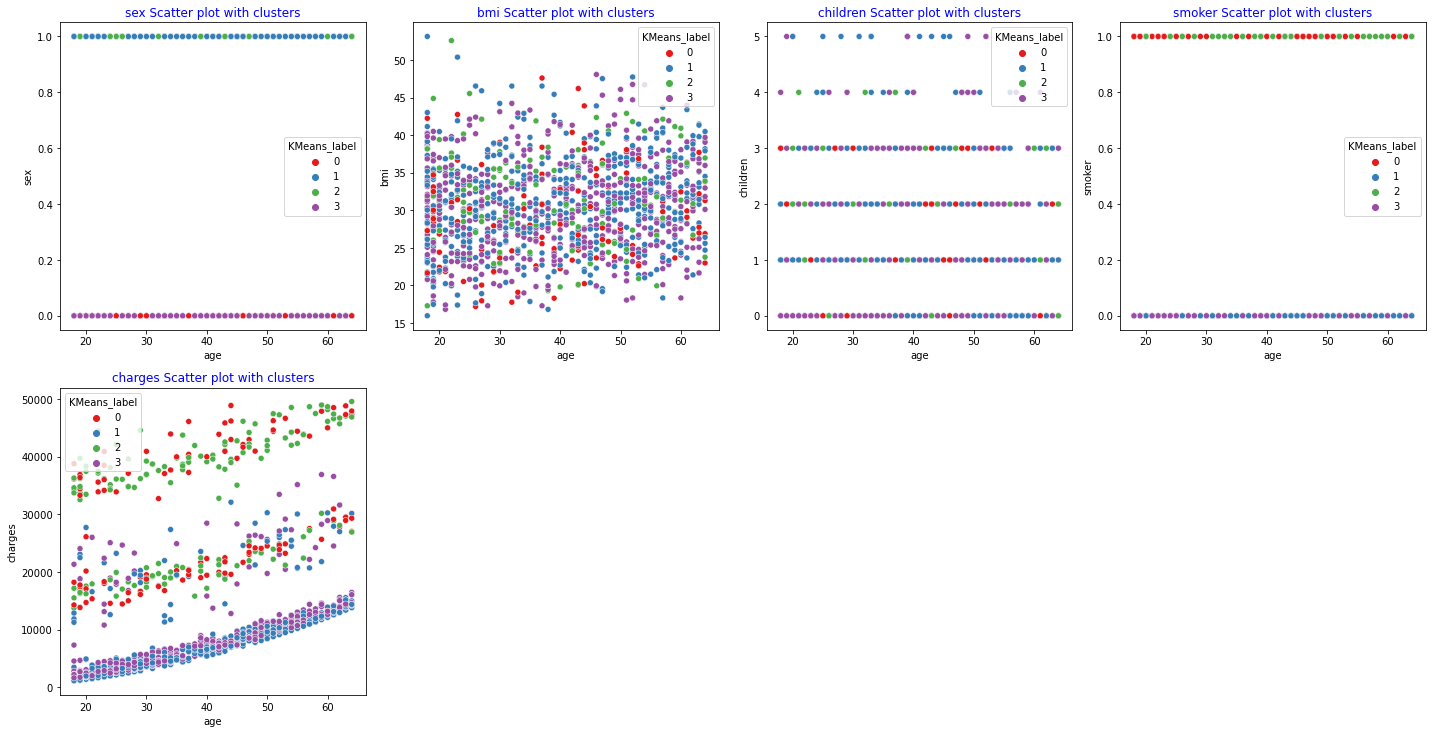

In [21]:
f=plt.figure(figsize=(20,20))
scatter_cols = ['sex', 'bmi', 'children', 'smoker', 'charges']

for i, col in enumerate(scatter_cols):
    ax = f.add_subplot(4,4,i+1)
    sns.scatterplot(data=data_filtered, x="age",y=col,hue="KMeans_label",palette="Set1")
    ax.set_title(col+" Scatter plot with clusters",color="blue")
    plt.ylabel(col)
f.tight_layout()

I modeled K-Means for all the features and it yileded graphs above.

In [22]:
# KMeans on selected features
sample_df = pd.DataFrame([data_filtered["charges"],data_filtered["age"]])
sample_df = sample_df.T
sample_df.head()

,charges,age
0,16884.92400,19.0
1,1725.55230,18.0
2,4449.46200,28.0
3,21984.47061,33.0
4,3866.85520,32.0


In [23]:
# Again I used MinMaxScaler here
scaler = MinMaxScaler()
Sample_Scaled_df = scaler.fit_transform(sample_df)

In [24]:
km_sample = KMeans(n_clusters=4)
km_sample.fit(Sample_Scaled_df)

KMeans(n_clusters=4)

In [25]:
km_labels_sample = km_sample.labels_
sample_df['km_label'] = km_labels_sample

# I added labels to the dataframe for further use

### Agglomerative Clustering

In [26]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=4, affinity="euclidean", linkage="single")
ac.fit(data_cleaned)
labels = ac.labels_

In [27]:
data_filtered["ac_lables"] = labels

In [28]:
#Agglomerative on selected features
#We have already created sample scaled df

ac_sample = AgglomerativeClustering(n_clusters=4, affinity="euclidean",linkage="ward")
ac_sample.fit(Sample_Scaled_df)

AgglomerativeClustering(n_clusters=4)

In [29]:
ac_labels_sample = ac_sample.labels_
sample_df["ac_labels"] = ac_labels_sample

## Comparison of Clusters

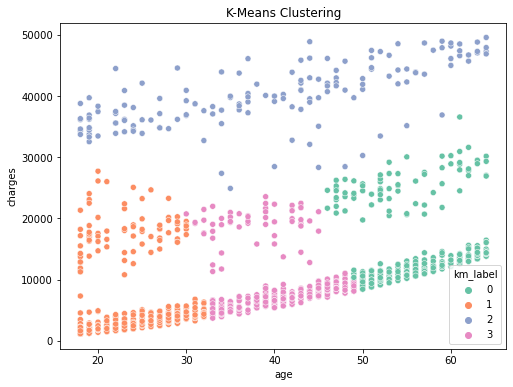

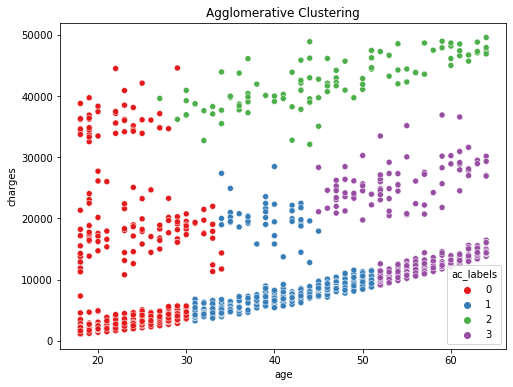

In [30]:
plt.figure(figsize=(8,6))
plt.title("K-Means Clustering")
sns.scatterplot(data= sample_df, x="age", y="charges", hue= "km_label", palette='Set2')
plt.show()

plt.figure(figsize=(8,6))
plt.title("Agglomerative Clustering")
sns.scatterplot(data= sample_df, x="age", y="charges", hue= "ac_labels", palette='Set1')
plt.show()

Final clusters for both of the models are shown here. K-Means created a whole group above where Agglomerative clustering created two different clusters there. Other than the upper part models yielded similar clusters. 

## Silhouette Scores

In [31]:
sample_df.head()

# Here we can use km_labels and ac_labels for silhouette score.

,charges,age,km_label,ac_labels
0,16884.92400,19.0,1,0
1,1725.55230,18.0,1,0
2,4449.46200,28.0,1,0
3,21984.47061,33.0,3,0
4,3866.85520,32.0,1,1


#### K-Means 

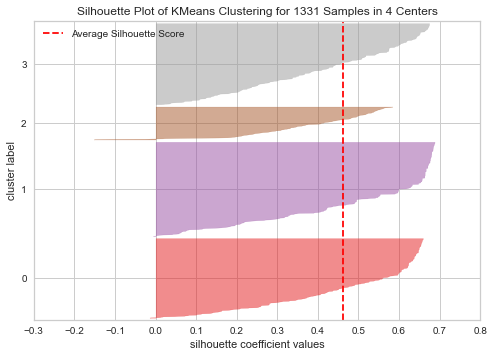

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 1331 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [32]:
from yellowbrick.cluster import SilhouetteVisualizer

km_visualizer = SilhouetteVisualizer(km_sample)
km_visualizer.fit(Sample_Scaled_df)
km_visualizer.poof()

This is the result of silhouete analysis of K-Means clustering algorithm. It has mostly yielded positive silhouette values for the data points which means clustering is mostly done correctly.

#### Agglomerative Clustering

In [33]:
from sklearn.metrics import silhouette_samples,silhouette_score

silhouette_avg = silhouette_score(X= Sample_Scaled_df, labels = ac_labels_sample)
sample_silhouette_values = silhouette_samples(Sample_Scaled_df, ac_labels_sample)

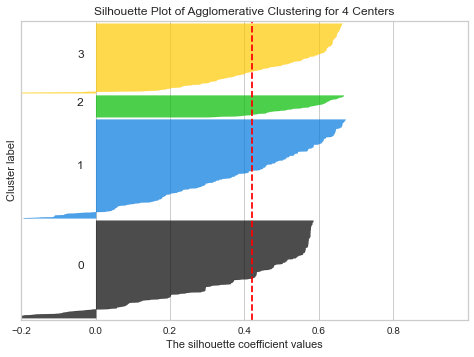

In [34]:
# There were no libraries for silhouette plots for agglomerative clustering as far as I researched.
# So I created it myself with the help of this resource. 
#   https://scikit-learn.org/stable/auto_examples/cluster/
#   plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py


import matplotlib.cm as cm

fig , ax = plt.subplots(1,1)
ax.set_xlim([-0.1, 1])
ax.set_ylim([0, len(Sample_Scaled_df) + 50])


y_lower = 10
for i in range(4):
    ith_cluster_silhouette_values = sample_silhouette_values[ac_labels_sample == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i)/4)
    ax.fill_betweenx(
        np.arange(y_lower,y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )
    ax.text(-0.05,y_lower+0.5*size_cluster_i,str(i))
    y_lower = y_upper + 10

ax.set_title("Silhouette Plot of Agglomerative Clustering for 4 Centers")
ax.set_xlabel("The silhouette coefficient values")
ax.set_ylabel("Cluster label")

ax.axvline(x=silhouette_avg, color="red", linestyle="--")

ax.set_yticks([])  # Clear the yaxis labels / ticks
ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8])
fig.show()

This is the silhouette plot for Agglomerative clustering. As we can see this model yielded more negative scores than the K-Means, this shows us it had more false clustered data points than K-Means.

### Comparison of K-Means and Agglomerative Clustering

In [35]:
k_means_score = silhouette_score(Sample_Scaled_df, km_labels_sample)
ac_score = silhouette_score(Sample_Scaled_df, ac_labels_sample)

print("K-Means Clustering Silhouette Score for 4 clusters:\t\t%.2f"%(k_means_score))
print("Agglomerative Clustering Silhouette Score for 4 clusters:\t%.2f"%(ac_score))

K-Means Clustering Silhouette Score for 4 clusters:		0.46
Agglomerative Clustering Silhouette Score for 4 clusters:	0.42


If we look at the overall scores of two models we can see K-Means created better results, so it is the better algorithm for this case.